In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score

from typing import List, Tuple

sns.set(style='darkgrid')
sns.set_palette('dark')

In [2]:
train = pd.read_csv('/mnt/f/data/kg/HW2/assignment_train.csv')
test = pd.read_csv('/mnt/f/data/kg/HW2/assignment_test.csv')

### Задания на повторение

#### Задание 1
Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

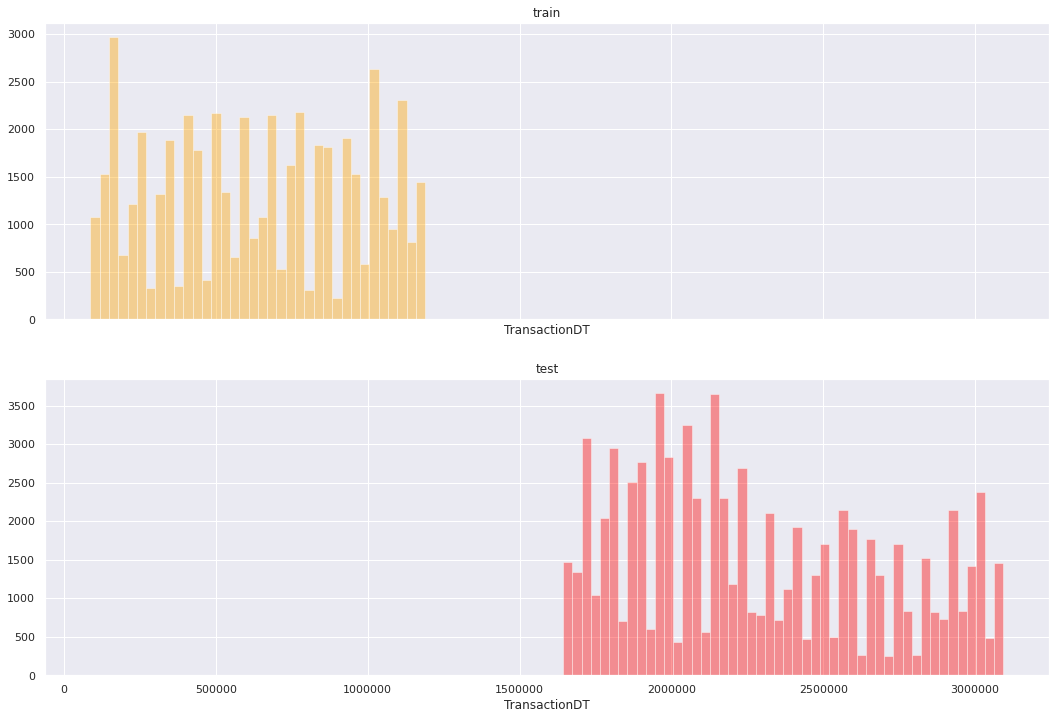

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
axes[0].ticklabel_format(style='plain')
axes[1].ticklabel_format(style='plain')
# fig.tight_layout()
g = sns.distplot(train.TransactionDT, ax=axes[0], kde=False, color='orange').set_title('train')
g = sns.distplot(test.TransactionDT, ax=axes[1], kde=False, color='red').set_title('test')

Видно, что данные разбиты по времени. В обучающей выборке более ранние, в тестовой более поздние. Выборки не пересекаются, кроме того, определенный интервал времени пропущен полностью. Для таких данных целесообразно использовать разбиение по времени, т.е. без перемешивания.

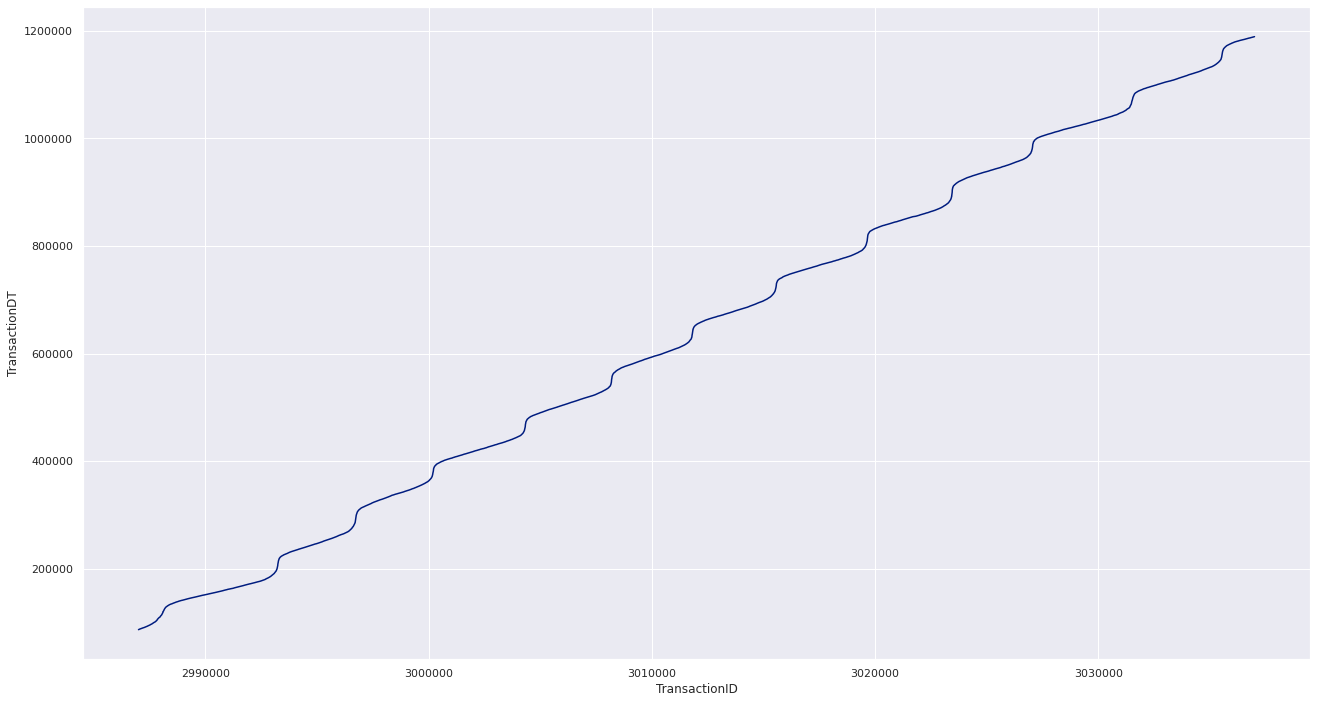

In [4]:
fig, ax = plt.subplots(1, figsize=(22, 12))
ax.ticklabel_format(style='plain')
g = sns.lineplot(x='TransactionID', y='TransactionDT', data=train, ax=ax)

Функция зависимости ID транзакции от времени является монотонно возрастающей, поэтому можно делить данные по `TransactionID`.

#### Задание 2
Построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

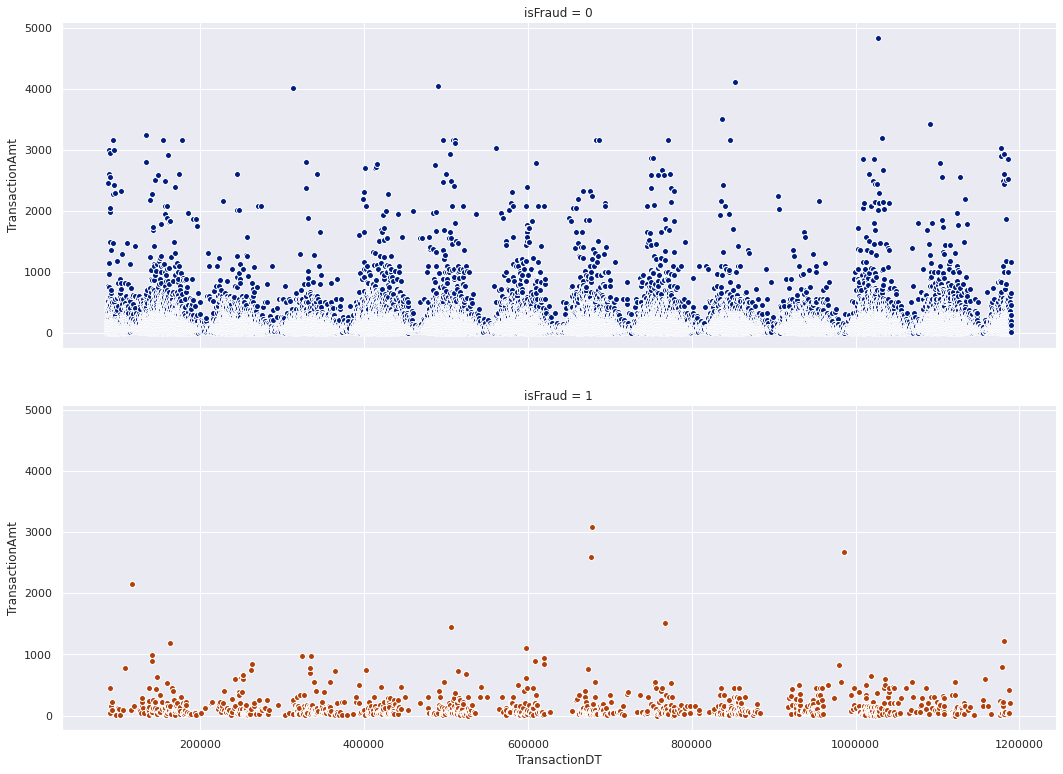

In [5]:
g = sns.FacetGrid(train, row='isFraud', hue='isFraud')
plt.ticklabel_format(style='plain')
g = g.map(plt.scatter, 'TransactionDT', 'TransactionAmt', edgecolor='w')
g.fig.set_figheight(12)
g.fig.set_figwidth(22)

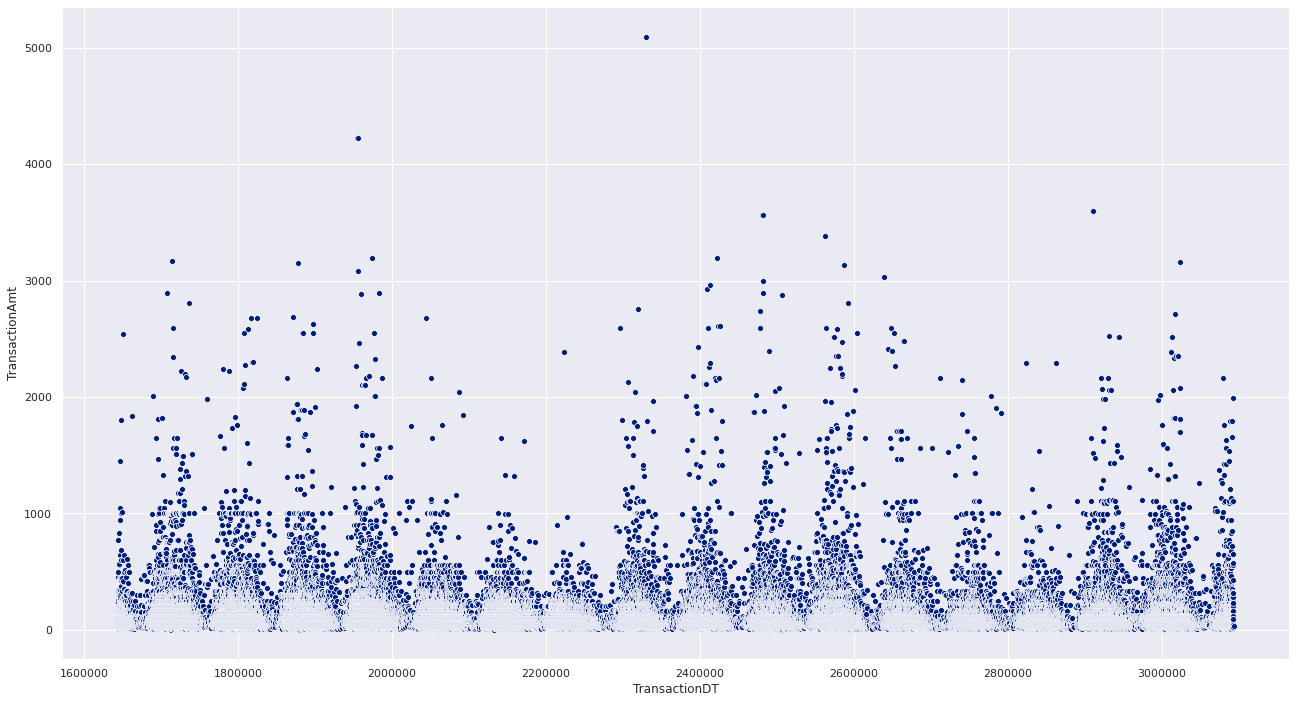

In [6]:
fig = plt.figure(figsize=(22, 12))
g = sns.scatterplot(x='TransactionDT', y='TransactionAmt', data=test)
plt.ticklabel_format(style='plain')

Сумма большинства транзакций $\leq 1000$ в обучающей и тестовой выборке, при этом количество мошеннических транзакций на сумму $> 1000$ сравнительно меньше, чем для легитимных. Возможно, мошенники стараются не вызывать подозрений.

Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

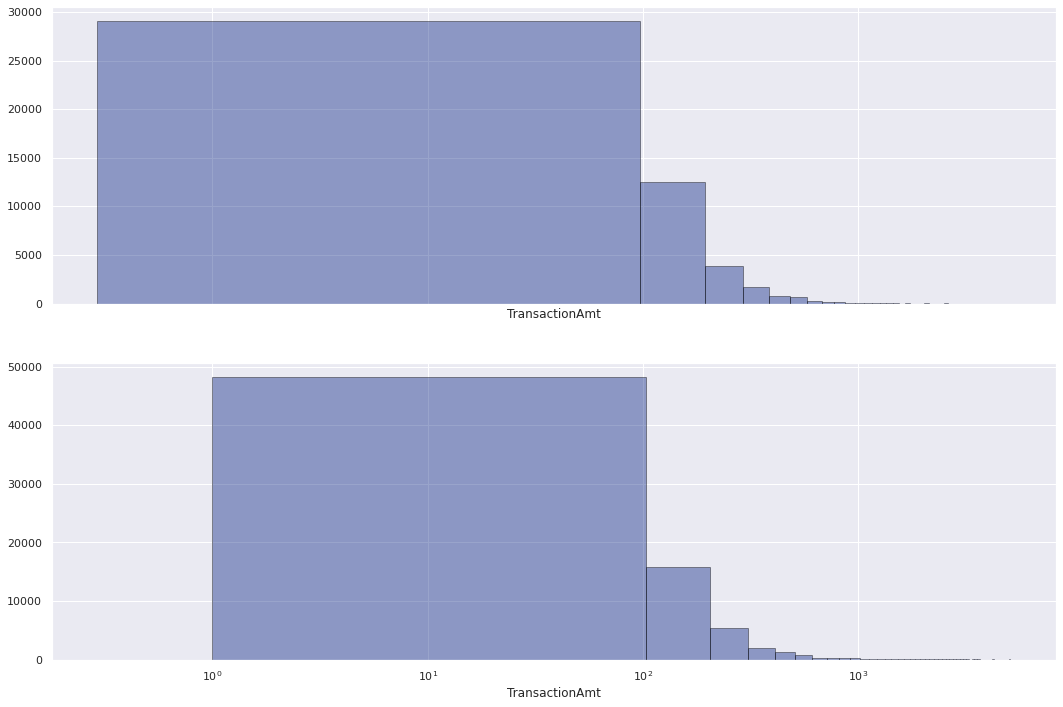

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
axes[0].set(xscale='log')
axes[1].set(xscale='log')
g = sns.distplot(train.TransactionAmt, ax=axes[0], kde=False, hist_kws={'edgecolor': (0, 0, 0, 0)})
g = sns.distplot(test.TransactionAmt, ax=axes[1], kde=False, hist_kws={'edgecolor': (0, 0, 0, 0)})

Распределение на нормалальное не похоже совсем ни в обучающей, ни в тестовой выборке. Тестовая выборка не содержит значение в диапазоне от 0 до 1, а в остальном распределения похожи.

#### Задание 4
Построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

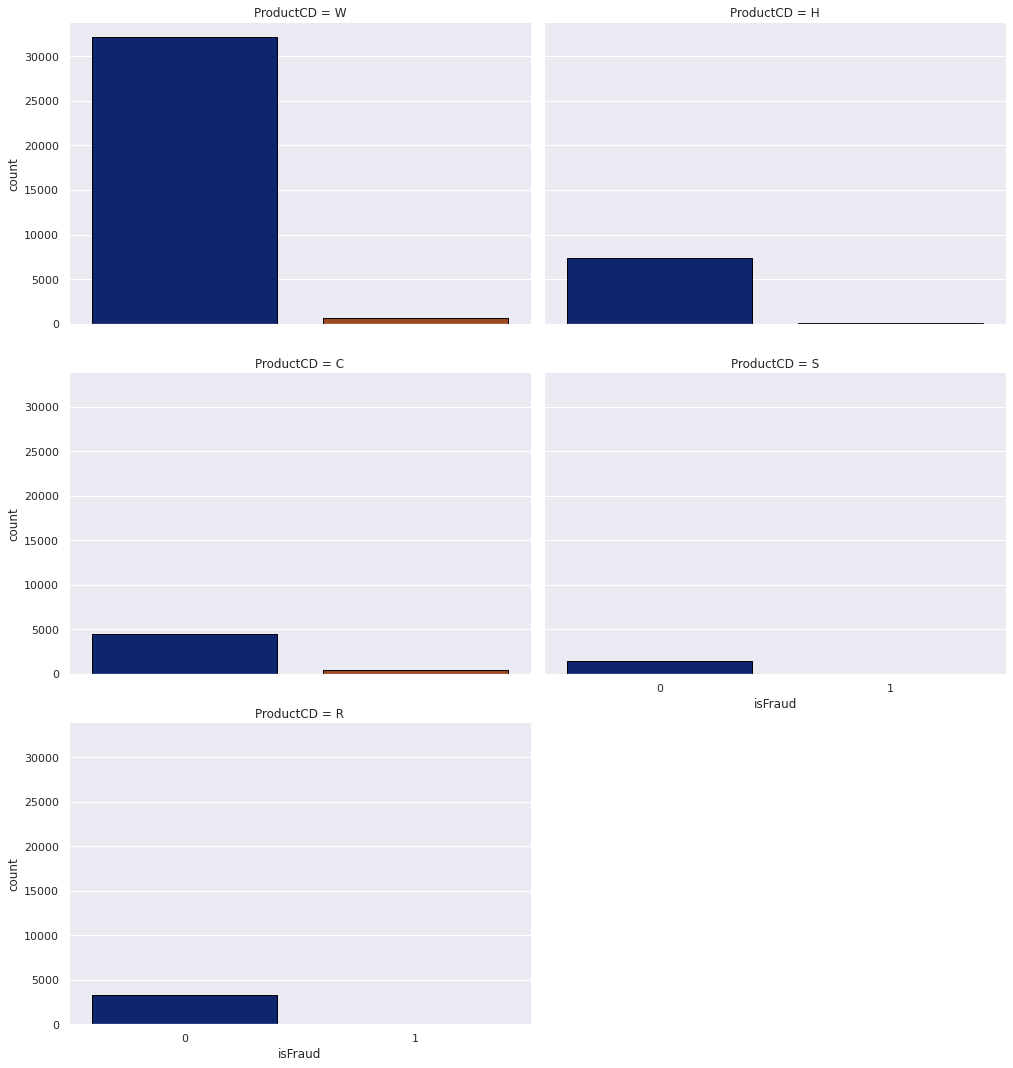

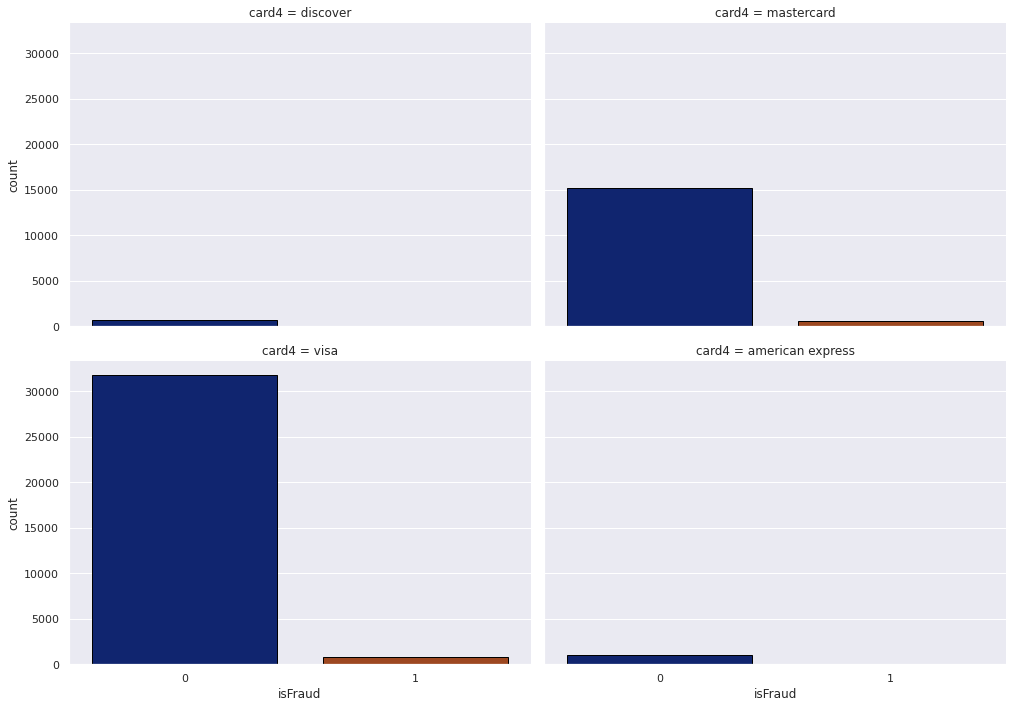

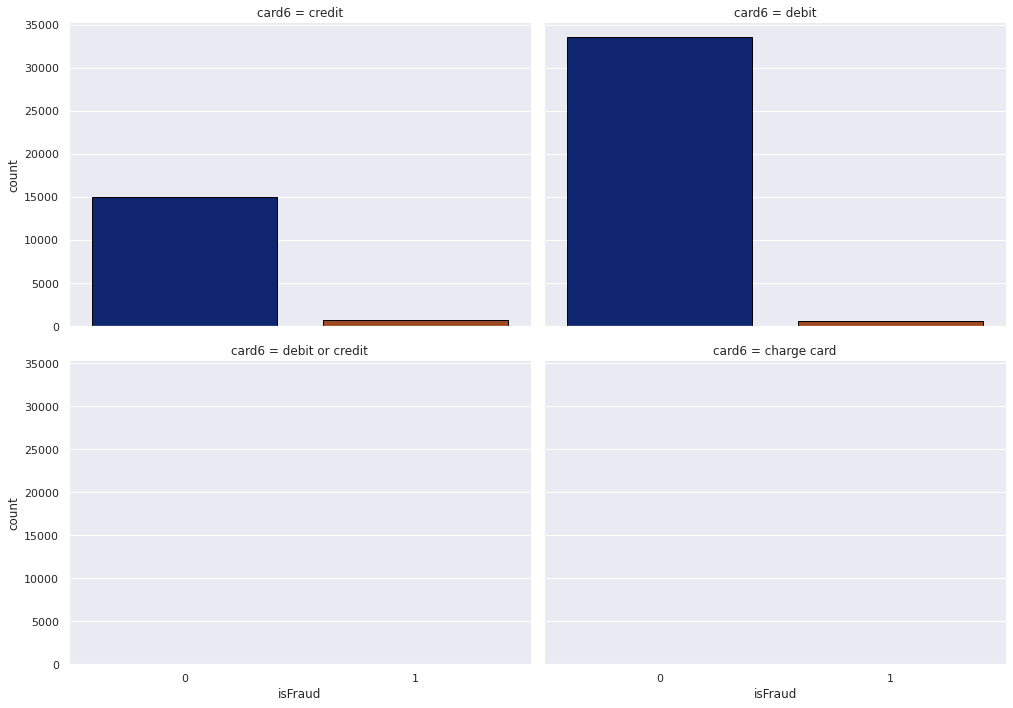

In [8]:
for var in ['ProductCD', 'card4', 'card6']:
    g = sns.catplot(x='isFraud', data=train, kind='count', col=var, col_wrap=2, ec='black', aspect=1.4)

In [9]:
train.loc[(train.card6 == 'debit or credit')|(train.card6 == 'charge card')]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
16408,3003408,0,435569,58.510,W,4648,555.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23523,3010523,0,600519,19.757,C,8404,156.0,146.0,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27859,3014859,0,695531,25.000,W,2572,555.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43216,3030216,0,1036297,58.430,W,4648,555.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47201,3034201,0,1120297,28.509,C,8404,156.0,146.0,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47306,3034306,0,1121538,50.604,C,8404,156.0,146.0,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


На графиках видно, что в целом мошеннические транзакции довольно редкие. Для некоторых значений таких транзакции нет вообще (но их просто мало). В некоторых категорях мошеннических транзакций сравнительно больше, чем в других (`ProductCD = C`, `card4 = mastercard`, `card6 = credit`). Можно предположить, что некоторые типы карт более популярны у мошенников.

##### Основное задание
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

#### Задание 1 
Сделать Hold-Out валидацию с разбиением, размер которого будет адкватным, по вашему мнению; разбиение проводить по id-транзакции (`TransactionID`), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [10]:
test.sort_values('TransactionID', inplace=True)
X_other_test = test.drop('isFraud', axis=1)
y_other_test = test.isFraud

In [11]:
train.sort_values('TransactionID', inplace=True)
X = train.drop('isFraud', axis=1)
y = train.isFraud

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=43)

In [13]:
categorical_features = X_train.select_dtypes('object').columns.tolist()
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()

In [14]:
eval_set = [(X_valid[numeric_features], y_valid)]

In [15]:
clf = xgb.XGBClassifier(n_estimators=50, n_jobs=3)

In [16]:
clf.fit(X_train[numeric_features],
        y_train,
        eval_metric='auc',
        eval_set=eval_set,
        early_stopping_rounds=7)

[0]	validation_0-auc:0.78629
Will train until validation_0-auc hasn't improved in 7 rounds.
[1]	validation_0-auc:0.84951
[2]	validation_0-auc:0.84749
[3]	validation_0-auc:0.85039
[4]	validation_0-auc:0.85167
[5]	validation_0-auc:0.87253
[6]	validation_0-auc:0.87509
[7]	validation_0-auc:0.88000
[8]	validation_0-auc:0.88115
[9]	validation_0-auc:0.88511
[10]	validation_0-auc:0.88485
[11]	validation_0-auc:0.88599
[12]	validation_0-auc:0.89037
[13]	validation_0-auc:0.88987
[14]	validation_0-auc:0.89058
[15]	validation_0-auc:0.89244
[16]	validation_0-auc:0.89205
[17]	validation_0-auc:0.89413
[18]	validation_0-auc:0.89593
[19]	validation_0-auc:0.89758
[20]	validation_0-auc:0.89913
[21]	validation_0-auc:0.90199
[22]	validation_0-auc:0.90388
[23]	validation_0-auc:0.90870
[24]	validation_0-auc:0.90588
[25]	validation_0-auc:0.90728
[26]	validation_0-auc:0.90758
[27]	validation_0-auc:0.90760
[28]	validation_0-auc:0.90749
[29]	validation_0-auc:0.90765
[30]	validation_0-auc:0.90751
Stopping. Best it

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=3, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
preds_valid = clf.predict_proba(X_valid[numeric_features])

In [18]:
roc_auc_score(y_valid, preds_valid[:, 1])

0.9087054649311297

In [19]:
preds_test = clf.predict_proba(X_other_test[numeric_features])

In [20]:
roc_auc_score(y_other_test, preds_test[:, 1])

0.8664180706247222

Разница между результатом на обучающей и на тестовой выборке в пределе разумнго — менее 5%.

#### Задание 2
Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (`TransactionID`), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=43)

In [22]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, shuffle=False, test_size=0.3, random_state=43)

In [23]:
eval_set = [(X_valid[numeric_features], y_valid),
            (X_test[numeric_features], y_test),
            (X_other_test[numeric_features], y_other_test)]

In [24]:
clf.fit(X_train[numeric_features],
        y_train,
        eval_metric='auc',
        eval_set=eval_set,
        early_stopping_rounds=7)

[0]	validation_0-auc:0.79991	validation_1-auc:0.74701	validation_2-auc:0.76588
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 7 rounds.
[1]	validation_0-auc:0.85864	validation_1-auc:0.82405	validation_2-auc:0.81088
[2]	validation_0-auc:0.85944	validation_1-auc:0.81434	validation_2-auc:0.81773
[3]	validation_0-auc:0.86123	validation_1-auc:0.82044	validation_2-auc:0.81855
[4]	validation_0-auc:0.86537	validation_1-auc:0.81367	validation_2-auc:0.82199
[5]	validation_0-auc:0.88258	validation_1-auc:0.84474	validation_2-auc:0.83448
[6]	validation_0-auc:0.88427	validation_1-auc:0.84949	validation_2-auc:0.83575
[7]	validation_0-auc:0.88896	validation_1-auc:0.85464	validation_2-auc:0.83917
[8]	validation_0-auc:0.89235	validation_1-auc:0.84969	validation_2-auc:0.85066
[9]	validation_0-auc:0.89175	validation_1-auc:0.86625	validation_2-auc:0.85160
[10]	validation_0-auc:0.89528	validation_1-auc:0.85515

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=3, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Здесь итоговый результат на валидационной выборке оказался немного ниже. Разница между валидационной и тестовой выборкой составляет 2%. Разница между тестовой и отдельной тестовой выборкой составляет менее 1.5%.

#### Задание 3
Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [25]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [26]:
np.random.seed(43)
scores = create_bootstrap_metrics(y_test, clf.predict_proba(X_test[numeric_features])[:, 1], roc_auc_score)

In [27]:
calculate_confidence_interval(scores)

(0.8299042659314974, 0.922428694814082)

In [28]:
roc_auc_score(y_other_test, clf.predict_proba(X_other_test[numeric_features])[:, 1])

0.8665546888711717

Доверительный интервал достаточно большой, но результат, полученный на отдельно выборке, лежит в нем $\rightarrow$ валидация работает.

Text(0.5, 0, 'Sample number')

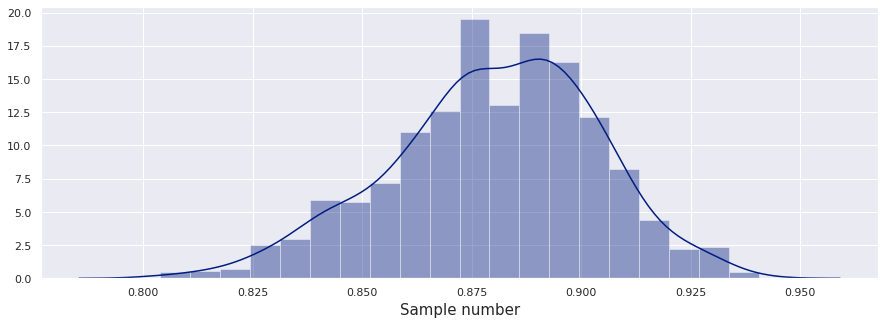

In [29]:
fig, ax = plt.subplots( figsize=(15, 5))
sns.distplot(scores, ax=ax, bins=20)
ax.set_xlabel("Sample number", size=15)

#### Задание 4
Выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [30]:
X_adv = pd.concat([X[numeric_features],
                   X_other_test[numeric_features]],
                   axis=0)
X_adv = X_adv.reset_index(drop=True)
X_adv = X_adv.sample(frac=1)
y_adv = np.hstack((np.zeros(X.shape[0]), np.ones(X_other_test.shape[0])))

In [31]:
clf = xgb.XGBClassifier(n_estimators=10)
clf.fit(X_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
preds = clf.predict_proba(X[numeric_features])[:, 1]

In [33]:
X_train = X[preds <= 0.6]
X_valid = X[preds > 0.6]
y_train = y[preds <= 0.6]
y_valid = y[preds > 0.6]

In [34]:
clf = xgb.XGBClassifier(n_estimators=50)

In [35]:
eval_set = [(X_valid[numeric_features], y_valid), (X_other_test[numeric_features], y_other_test)]

In [36]:
clf.fit(X_train[numeric_features],
        y_train,
        eval_metric='auc',
        eval_set=eval_set,
        early_stopping_rounds=7)

[0]	validation_0-auc:0.77253	validation_1-auc:0.77591
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 7 rounds.
[1]	validation_0-auc:0.83014	validation_1-auc:0.81231
[2]	validation_0-auc:0.83733	validation_1-auc:0.81559
[3]	validation_0-auc:0.84038	validation_1-auc:0.81934
[4]	validation_0-auc:0.84222	validation_1-auc:0.82315
[5]	validation_0-auc:0.85343	validation_1-auc:0.83346
[6]	validation_0-auc:0.85255	validation_1-auc:0.84362
[7]	validation_0-auc:0.85341	validation_1-auc:0.84571
[8]	validation_0-auc:0.86067	validation_1-auc:0.85856
[9]	validation_0-auc:0.86310	validation_1-auc:0.86246
[10]	validation_0-auc:0.87004	validation_1-auc:0.86949
[11]	validation_0-auc:0.87304	validation_1-auc:0.87336
[12]	validation_0-auc:0.87689	validation_1-auc:0.87381
[13]	validation_0-auc:0.87939	validation_1-auc:0.87266
[14]	validation_0-auc:0.87847	validation_1-auc:0.87000
[15]	validation_0-auc:0.87913

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Таким образом, получилось, что качество на отдельной тестовой выборке несколько улучшилось.

#### Задание 5
Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных.

In [37]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [38]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=False)

In [39]:
%%time
estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X[numeric_features], y, clf, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.7032, valid-score = 0.5843
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.7141, valid-score = 0.6065
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.7094, valid-score = 0.6594
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.6929, valid-score = 0.6359
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.7004, valid-score = 0.5511
CV-results train: 0.704 +/- 0.007
CV-results valid: 0.6074 +/- 0.038
OOF-score = 0.6074
CPU times: user 1min 47s, sys: 4.69 s, total: 1min 52s
Wall time: 40.9 s


#### Задание 6 * (опциональное)
Сделать Hold-Out валидацию по времени (`TransactionDT`), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

In [40]:
test.sort_values('TransactionDT', inplace=True)
X_other_test = test.drop('isFraud', axis=1)
y_other_test = test.isFraud

In [41]:
train.sort_values('TransactionDT', inplace=True)
X = train.drop('isFraud', axis=1)
y = train.isFraud

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=43)

In [43]:
np.random.seed(43)
scores = create_bootstrap_metrics(y_test, clf.predict_proba(X_test[numeric_features])[:, 1], roc_auc_score)
calculate_confidence_interval(scores)

(0.851445878717973, 0.9012313782717752)

In [44]:
roc_auc_score(y_other_test, clf.predict_proba(X_other_test[numeric_features])[:, 1])

0.8399891455901964

Доверительный интервал, полученный таким образом, стал меньше, при этом метрика на отдельной тестовой выборке почти в него не вписывается.

#### Задание 7 ** (совсем опциональное)
В данном наборе данных у нас есть ID-транзакции (`TransactionID`) и время транзакции (`TransactionDT`), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

Уникальным идентификатором может служить целое число. Есть подозрение, что `card1` таковым и является, хотя возможно, что это не идентификатор самого клиента, а карты.

In [45]:
train.select_dtypes('int64').columns.tolist()

['TransactionID', 'isFraud', 'TransactionDT', 'card1']

Общее количество значений относительно всей выборки усиливает это подозрение.

In [46]:
train.card1.nunique()

5446

Здесь непонятно о каком периоде времени идет речь (т.е. какая размерность у `TransactionDT`), но такие среднее и медиана выглядят резонно.

In [47]:
train.groupby('card1').count()['TransactionID'].median()

2.0

In [48]:
train.groupby('card1').count()['TransactionID'].mean()

9.181233933161954

In [49]:
train.card1.notna().all()

True

In [50]:
test.card1.nunique()

6716

В принципе ожидаемо, что есть пересечения.

In [51]:
len(set(train.card1).intersection(set(test.card1)))

3850

In [52]:
len(set(train.card1).union(set(test.card1)))

8312

In [59]:
test.sort_values('card1', inplace=True)
X_other_test = test.drop('isFraud', axis=1)
y_other_test = test.isFraud

In [60]:
train.sort_values('card1', inplace=True)
X = train.drop('isFraud', axis=1)
y = train.isFraud

In [61]:
groups = X.card1.values.tolist()

In [62]:
cv_strategy = GroupKFold(n_splits=5)

In [63]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,
                          groups: List):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y, groups)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [64]:
%%time
estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X[numeric_features], y, clf, metric=roc_auc_score, cv_strategy=cv_strategy, groups=groups
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.7016, valid-score = 0.672
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.7041, valid-score = 0.6577
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.6993, valid-score = 0.6209
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.7075, valid-score = 0.6635
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.6998, valid-score = 0.6153
CV-results train: 0.7025 +/- 0.003
CV-results valid: 0.6459 +/- 0.023
OOF-score = 0.4999
CPU times: user 1min 47s, sys: 4.19 s, total: 1min 51s
Wall time: 40.7 s


Результат несколько лучше на валидационных данных, на OOF сильно хуже.